<a href="https://colab.research.google.com/github/Ibraheem101/Made-With-ML/blob/dev/notebooks/mwml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLOPs**

[Mlops substack
](https://marvelousmlops.substack.com/p/bridging-the-gap-converting-data)

## **Setup**

### **Clone Github repository**

In [1]:
! git clone https://github.com/GokuMohandas/Made-With-ML.git

fatal: destination path 'Made-With-ML' already exists and is not an empty directory.


In [2]:
! pwd

/content


In [3]:
import os
print(os.getcwd())

/content


In [4]:
new_directory = "/content/Made-With-ML"
os.chdir(new_directory)

In [5]:
print(os.getcwd())

/content/Made-With-ML


In [6]:
import sys
sys.path.append('/content/Made-With-ML')

### **Install requirements**

In [7]:
! pip install --upgrade pip setuptools wheel

In [8]:
pip install -r requirements.txt

In [9]:
! pre-commit install
! pre-commit autoupdate

pre-commit installed at .git/hooks/pre-commit
Updating https://github.com/pre-commit/pre-commit-hooks ... updating v4.4.0 -> v4.5.0.


Support for third party widgets will remain active for the duration of the session. To disable support:

In [10]:
from google.colab import output
output.disable_custom_widget_manager()

In [11]:
import os
import re
import json
import math
import nltk
import time
import torch
import gensim
import random
import urllib
import tempfile
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [12]:
# Support for third party widgets
from google.colab import output
output.enable_custom_widget_manager()

### **Ray Setup**

In [13]:
# Issues with 2.7
# !pip install ray==2.6.0

In [14]:
import ray

In [15]:
ray.__version__

'2.7.0'

In [16]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-11-12 13:16:05,286	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.12', ray_version='2.7.0', ray_commit='b4bba4717f5ba04ee25580fe8f88eed63ef0c5dc', protocol_version=None)

In [17]:
ray.cluster_resources()

{'object_store_memory': 3952715366.0,
 'CPU': 2.0,
 'node:172.28.0.12': 1.0,
 'GPU': 1.0,
 'memory': 7905430734.0,
 'node:__internal_head__': 1.0,
 'accelerator_type:None': 1.0}

In [18]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU": 1, "GPU": 1}

## **Data**

In [19]:
import pandas as pd

In [20]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

id           created_on                                              title   
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...  \
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  25  2020-03-07 23:04:31                                      AttentionWalk   

                                         description              tag  
0  Bringing theory to experiment is cool. We can ...  computer-vision  
1  The beauty of the work lies in the way it arch...  computer-vision  
2  A collection of important graph embedding, cla...            other  
3  A curated list of Monte Carlo tree search pape...            other  
4  A PyTorch Implementation of "Watch Your Step: ...            other

In [21]:
df.to_csv("mwml_dataset.csv", index=False)

In [22]:
df.tag.unique()

array(['computer-vision', 'other', 'natural-language-processing', 'mlops'],
      dtype=object)

### **Data Splitting**

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

What are the criteria we should focus on to ensure proper data splits?
* Randomness
* Stratification (for imbalanced datasets)
* Sufficient data size in each subset
* Temporal data handling (for time-series data)
* Consistency across models
* Reproducibility with random seed
* Adequate validation set size for hyperparameter tuning
* Complete separation of the test set from training and validation data.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           764 non-null    int64 
 1   created_on   764 non-null    object
 2   title        764 non-null    object
 3   description  764 non-null    object
 4   tag          764 non-null    object
dtypes: int64(1), object(4)
memory usage: 30.0+ KB


In [26]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [27]:
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [28]:
val_df.tag.value_counts()

tag
natural-language-processing    62
computer-vision                57
other                          21
mlops                          13
Name: count, dtype: int64

In [29]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

### **Exploratory Data Analysis**

In [30]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [31]:
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

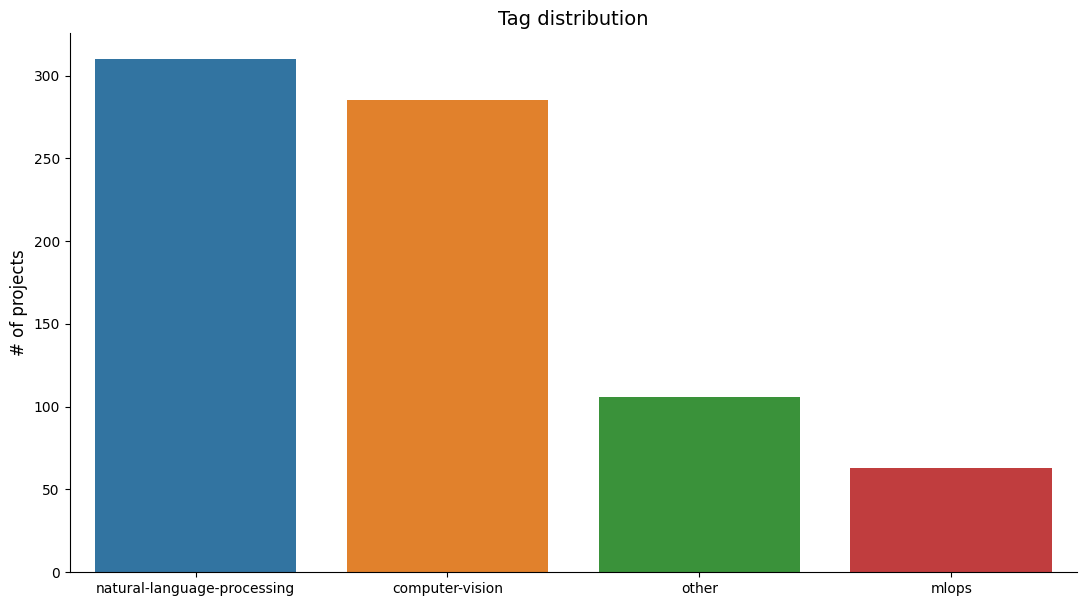

In [32]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(13, 7))
sns.barplot(x=list(tags), y=list(tag_counts))
sns.despine()
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()
# plt.xticks(rotation=45)

There's some data imbalance but we'll deal with that before modeling

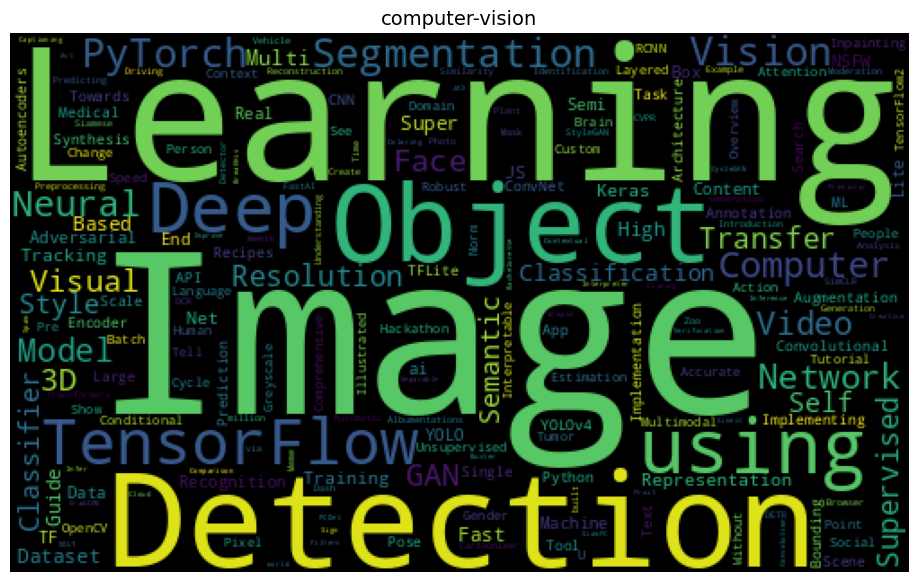

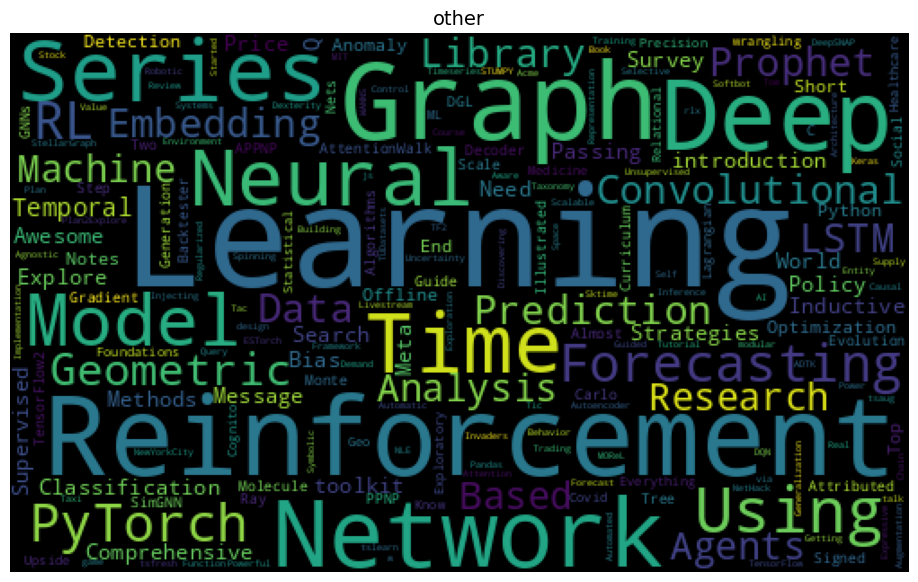

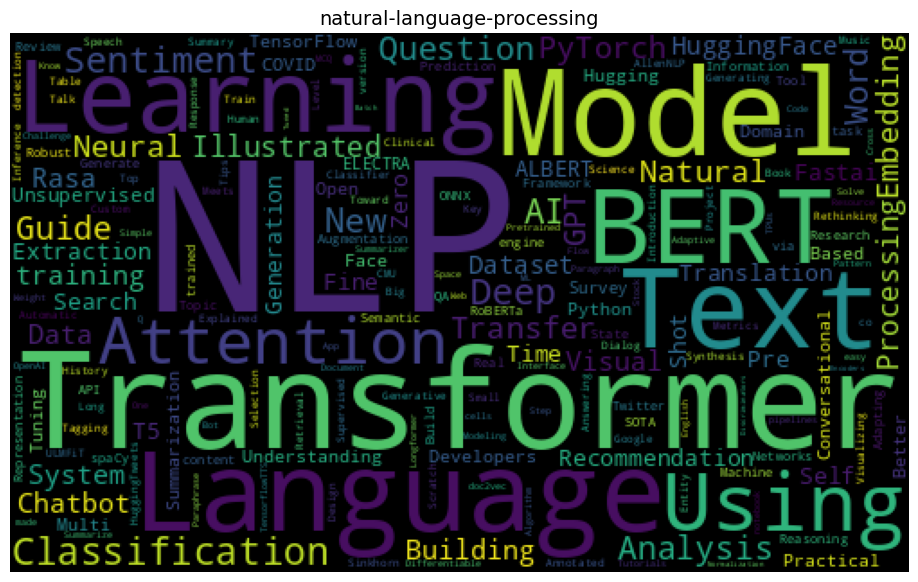

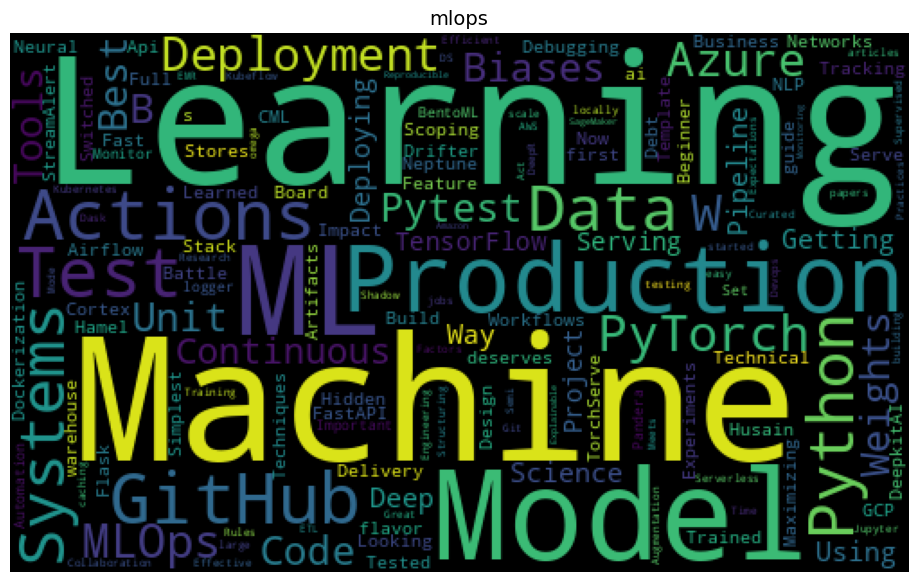

In [33]:
# Examine word distribution
# Create a list to store the generated WordCloud plots
cloud_plots = []

for tag in df['tag'].unique():
    plt.figure(figsize=(13, 7))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color='black', collocations=False,
        width=500, height=300).generate(" ".join(text)) #function requires a single string as input
    plt.axis("off")
    plt.imshow(cloud)
    plt.title(tag, fontsize=14)
    cloud_plots.append(plt)  # Store the current plot

# Adjust spacing between subplots
plt.subplots_adjust(wspace=2, hspace=0.5)

# Display all the plots
plt.show()


### **Preprocessing**

In [34]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [35]:
df.iloc[0]

id                                                             6
created_on                                   2020-02-20 06:43:18
title          Comparison between YOLO and RCNN on real world...
description    Bringing theory to experiment is cool. We can ...
tag                                              computer-vision
Name: 0, dtype: object

#### **Feature engineering**

Here, we could use a project's title and description separately as features but we'll combine them to create one input feature.

In [36]:
df['text'] = df['title'] + ' ' + df['description']

#### **Cleaning**

In [37]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
def clean_text(text, stopwords = STOPWORDS):
    # lowercase
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [39]:
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [40]:
df.head(2)

id           created_on                                              title   
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...  \
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   

                                         description              tag   
0  Bringing theory to experiment is cool. We can ...  computer-vision  \
1  The beauty of the work lies in the way it arch...  computer-vision   

                                                text  
0  comparison yolo rcnn real world videos bringin...  
1  show infer tell contextual inference creative ...

In [41]:
# Drop unwanted columns
df.drop(columns = ['id', 'created_on', 'title', 'description'], errors='ignore')
df = df.dropna(subset=["tag"])  # drop nulls
df = df[['text', 'tag']]
df.head()

text              tag
0  comparison yolo rcnn real world videos bringin...  computer-vision
1  show infer tell contextual inference creative ...  computer-vision
2  awesome graph classification collection import...            other
3  awesome monte carlo tree search curated list m...            other
4  attentionwalk pytorch implementation watch ste...            other

#### **Label Encoding**

In [42]:
tags = df.tag.unique().tolist()
num_classes = len(tags)

class_to_index = {tag : i for i, tag in enumerate(tags)}
class_to_index

{'computer-vision': 0,
 'other': 1,
 'natural-language-processing': 2,
 'mlops': 3}

In [43]:
# Encode labels
df['tag'] = df['tag'].map(class_to_index)
df['tag'].iloc[:5]

0    0
1    0
2    1
3    1
4    1
Name: tag, dtype: int64

In [44]:
# Decoding function
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [45]:
index_to_class = {value : key for key, value in class_to_index.items()}
decode(df['tag'].iloc[:5], index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

#### **Tokenize**

In [46]:
from transformers import BertTokenizer

In [47]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

(…)_scivocab_uncased/resolve/main/vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

(…)civocab_uncased/resolve/main/config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [48]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [49]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([0])}

Combine preprocessing operations

In [50]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [51]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([3, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 3, 2,
        2, 2, 2, 2, 0, 2, 0, 3, 1, 0, 3, 2, 2, 2, 2, 0, 2, 2, 3, 0, 1, 1,
        1, 3, 0, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 2, 3,
        2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 0, 1, 3, 2, 2,
        2, 2, 1, 1, 3, 0, 1, 0, 0, 2, 2, 1, 0, 1, 2, 2, 2, 2, 0, 3, 3, 0,
        2, 2, 0, 0, 2, 2, 3, 1, 2

### **Distributed**

#### **Setup**

By default, the preserve_order option is set to False, which allows Ray to execute operations in parallel and potentially optimize the execution for better performance. However, when you set it to True, Ray will prioritize maintaining the order of data, which may result in slower performance but deterministic output

In [52]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

In [53]:
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2023-11-12 13:16:22,945	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2023-11-12 13:16:22,965	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-11-12 13:16:22,973	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-12 13:16:22,978	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:16:22,983	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 1151,
  'created_on': datetime.datetime(2020, 6, 3, 7, 25, 27),
  'title': 'Web Mining and Information theory',
  'description': 'Mining the Web and playing with Natural Language processing. Implementing Information retrieval System tasks. Going towards the NLP and Performing Machine Learning algorithms. Through these codes and problems, I have understood the information retrieval process of any search engine. These are very useful problems towards sentiment analysis.',
  'tag': 'natural-language-processing'}]

#### **Splitting**
Next, we'll split our dataset into our training and validation splits. Ray has a built-in train_test_split function but we're using a modified version so that we can stratify our split based on the tag column.

In [54]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split

In [55]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-11-12 13:16:25,328	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-12 13:16:25,332	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:16:25,336	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
train_ds

RandomShuffle
+- MapBatches(_filter_split)
   +- MapBatches(group_fn)
      +- Sort
         +- RandomShuffle
            +- Dataset(
                  num_blocks=4,
                  num_rows=764,
                  schema={
                     id: int64,
                     created_on: timestamp[s],
                     title: string,
                     description: string,
                     tag: string
                  }
               )

In [57]:
val_ds

RandomShuffle
+- MapBatches(_filter_split)
   +- MapBatches(group_fn)
      +- Sort
         +- RandomShuffle
            +- Dataset(
                  num_blocks=4,
                  num_rows=764,
                  schema={
                     id: int64,
                     created_on: timestamp[s],
                     title: string,
                     description: string,
                     tag: string
                  }
               )

#### **Preprocessing**
One of the advantages of using Ray is that we won't have to change anything to our original Pandas-based preprocessing function we implemented in the previous lesson. Instead, we can use it directly with Ray's map_batches utility to map our preprocessing function across batches in our data in a distributed manner.

In [58]:
output.enable_custom_widget_manager()

In [59]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2023-11-12 13:16:26,186	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-12 13:16:26,187	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:16:26,190	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-12 13:16:27,966	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-12 13:16:27,973	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:16:27,975	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [60]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2023-11-12 13:16:29,525	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2023-11-12 13:16:29,529	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:16:29,530	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

{'ids': array([  102,  6317, 21024, 30121, 11257, 15567,  6317, 21024, 30121,
        6317, 13749,  1904,   551,   791, 11257, 15567,   103,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


## **Model**

### **Training**

#### **Distributed training**

The progression of model complexity follows a logical path from simple to more complex models, with each step building upon the previous one. Let's go through the progression and explain each step:

Random Model: This is the simplest baseline you can establish. It serves as a reference point to understand how your model is performing. Since it predicts labels randomly, it's not expected to provide any meaningful results. Its primary purpose is to set the lowest possible benchmark for model performance.

Rule-Based Model: The rule-based model introduces a bit more structure. Instead of random predictions, it tries to capture patterns in the input text and predict labels based on predefined rules. This model is still quite simple and typically manually defined, making it useful for scenarios where some domain-specific patterns can be identified without machine learning.

Logistic Regression with TF-IDF Vectors: Logistic Regression is a basic machine learning algorithm that works well as an initial modeling attempt. By using TF-IDF (Term Frequency-Inverse Document Frequency) vectors from text, this model attempts to capture relationships between words and labels. It's a form of feature-based modeling where the model learns the weights of features (words) to predict labels.

CNN (Convolutional Neural Network): CNNs are typically used for image processing, but they can also be applied to text data. In this case, the model applies character filters over the text, capturing local patterns. It's a more complex model compared to logistic regression and can capture spatial relationships between characters, which can be useful for tasks like text classification.

Fine-Tune Language Model (LLM): Fine-tuning a pre-trained language model is a more advanced approach. Here, you take a large language model pre-trained on a massive amount of text and fine-tune it on your specific task. This leverages the model's ability to understand contextual information in language, potentially improving performance on your task.

This progression from simple to complex models is a recommended practice because it allows you to gradually test and build upon different levels of model sophistication. Starting simple helps you establish a baseline, understand data preprocessing and modeling workflows, and identify potential challenges. As you move towards more complex models, you gain insights into how different techniques impact performance, and you can address more nuanced aspects of your data and task.

It's worth noting that the choice of model depends on your specific task, the available data, and the complexity of relationships in your data. Starting with simpler models can also help you avoid overfitting and ensure that the increased complexity of the model brings real benefits to your task.

#### **Setup**

In [61]:
from ray.data.preprocessor import Preprocessor

In [62]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [63]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [64]:
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        super(CustomPreprocessor, self).__init__()
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}

    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

    # def fit(self, ds):
    #     tags = ds.unique(column="tag")
    #     self.class_to_index = {tag: i for i, tag in enumerate(tags)}
    #     self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    #     return self

    # def transform(self, ds):
    #     return ds.map_batches(
    #         preprocess,
    #         fn_kwargs={"class_to_index": self.class_to_index},
    #         batch_format="pandas")

When working with very large datasets, it's a good idea to limit the number of samples in our dataset so that we can execute our code quickly and iterate on bugs, etc. This is why we have a num_samples input argument in our load_data function (None = no limit, all samples).

Faster Development Iteration: Large datasets can slow down the development and debugging process because running operations on the entire dataset can take a significant amount of time. By limiting the number of samples using the num_samples parameter, you can quickly execute your code, identify bugs, and test changes without waiting for the entire dataset to process.

Memory Efficiency: Loading and processing large datasets into memory can consume a substantial amount of memory resources. Limiting the number of samples allows you to work within memory constraints, making your code more efficient and preventing memory-related issues.

Exploratory Analysis: When exploring a dataset, you might not need to analyze every single data point. By selecting a representative subset of samples, you can perform exploratory analysis, understand the data's characteristics, and make initial observations more efficiently.

Debugging: Debugging code is easier with a smaller dataset since you can quickly identify errors and iterate on fixes. Once your code is working as expected, you can scale up to the entire dataset.

Code Validation: Before running your code on the entire dataset, it's a good practice to validate its correctness using a smaller sample. This helps catch issues early and ensures that your code behaves as intended.

However, keep in mind that using a subset of the data might not capture all the characteristics of the full dataset. Therefore, after validating and debugging your code with a limited number of samples, it's essential to test it on the full dataset to ensure it works properly in all scenarios.







##### **Model**

Now we're ready to start defining our model architecture. We'll start by loading a pretrained LLM and then defining the components needed for fine-tuning it on our dataset. Our pretrained LLM here is a transformer-based model that has been pretrained on a large corpus of scientific text called scibert.

![](https://media.arxiv-vanity.com/render-output/7086622/bert_pretraining.png)

In [65]:
from transformers import BertModel

In [66]:
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Once our model is loaded, we can tokenize an input text, convert it to torch tensors and pass it through our model to get a sequence and pooled representation of the text.

In [67]:
# Sample
text = ["BERT is a transformer model"]
batch = tokenizer(text, return_tensors="np", padding="longest")

In [68]:
{k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors

{'input_ids': tensor([[  102, 24921,   165,   106, 14982,   437,   103]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [69]:
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors

In [70]:
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

In [71]:
seq.shape, pool.shape

(torch.Size([1, 7, 768]), torch.Size([1, 768]))

1. Text Tokenization: The input text, "Transfer learning with transformers for text classification," is tokenized. This means it's split into smaller parts, usually words or subwords, which are called tokens. This tokenization is necessary because the language model understands text at the token level.

2. Batch Processing: The tokenized text is processed as a batch (a group of sentences or texts). In this case, there's only one text in the batch.

3. Model Input: The tokenized batch is then converted into a format that the pre-trained language model can understand. This format includes two main components:

* input_ids: These are numerical representations of the tokens. Each token is mapped to a unique ID.
* attention_mask: This mask tells the model which parts of the input are actual tokens and which are padding. Padding is added to make all input sequences the same length.
4. Passing Through the Language Model: The tokenized and formatted batch is passed through the pre-trained language model (LLM). This LLM has learned to understand the context and meaning of words and text.

5. Output: After passing through the LLM, you get two main outputs:

* seq: This represents the sequence of hidden states, which essentially means a representation of the input text after each token. It's like having a snapshot of the text's meaning after every word.
* pool: This represents a "pooled" or combined representation of the entire text. It condenses the information from the entire sequence into a single representation. This pooled representation is often used as input for downstream tasks like classification.
6. Classification Layer: Finally, this pooled representation (pool) is passed through a linear classifier (in this case, referred to as fc1). This classifier is trained to take the pooled representation and predict which class or category the input text belongs to. The number of classes is determined by num_classes.

In summary, the code tokenizes the text, passes it through a pre-trained language model to get both a sequence-level and a pooled representation of the text, and then uses these representations to classify the text into one of several possible categories or classes. The seq is like a detailed understanding of the text at each word, while pool is a condensed understanding of the entire text.






In [72]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs

    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [73]:
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print(model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

##### **Batching**

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (padding="longest"). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths.

In [74]:
from transformers import DataCollatorWithPadding

In [75]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [76]:
# # Sample batch
# sample_batch = sample_ds.take_batch(batch_size=128)
# data_collator(sample_batch)

In [77]:
from ray.train.torch import get_device

Created a temporary directory at /tmp/tmp8k8b0cgd
Writing /tmp/tmp8k8b0cgd/_remote_module_non_scriptable.py


In [78]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [79]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [80]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(sample_batch)

2023-11-12 13:16:42,236	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2023-11-12 13:16:42,242	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:16:42,244	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-79-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())


{'ids': tensor([[  102,  6317, 21024,  ...,     0,     0,     0],
         [  102,  2762,   784,  ...,     0,     0,     0],
         [  102, 10850,   142,  ...,     0,     0,     0],
         ...,
         [  102,  5363, 14440,  ...,     0,     0,     0],
         [  102,  3942,  8837,  ...,     0,     0,     0],
         [  102,   504,  3657,  ...,     0,     0,     0]], device='cuda:0',
        dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32),
 'targets': tensor([0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 3, 0, 2,
         2, 0, 2, 2, 1, 3, 0, 0, 0, 3, 1, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2,
         0, 3, 3, 2, 0, 3, 2, 3, 2, 3, 0, 0, 3, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 3,
         3, 0, 0, 2, 0, 3, 0, 2, 2, 0, 0, 0, 3, 3, 2, 

##### **Utilities**


![](https://madewithml.com/static/images/mlops/ray/train.svg)

In [81]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
from torch.nn.parallel.distributed import DistributedDataParallel

We'll start by defining what one step (or iteration) of training looks like. This will be a function that takes in a batch of data, a model, a loss function, and an optimizer. It will then perform a forward pass, compute the loss, and perform a backward pass to update the model's weights. And finally, it will return the loss.

In [82]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

* model.train(): This line tells the machine learning model that it's in training mode. During training, the model learns from data and adjusts its parameters to make better predictions.

* loss = 0.0: This initializes a variable called loss to zero. It will be used to keep track of the cumulative loss during one training iteration.

* ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn): This line creates a generator called ds_generator that iterates through the dataset ds in batches of a specified size (batch_size). The collate_fn function is likely used to collate or organize the data in each batch.

* for i, batch in enumerate(ds_generator):: This is a loop that iterates over each batch of data in the ds_generator. The loop keeps track of the batch number using i, and batch contains a batch of data.

* optimizer.zero_grad(): Before computing gradients, this line resets or clears any previously calculated gradients. Gradients are used to update the model's parameters during training.

* z = model(batch): Here, the machine learning model (model) takes the current batch of data (batch) as input and produces predictions (z) for that batch.

* targets = F.one_hot(batch["targets"], num_classes=num_classes).float(): This line one-hot encodes the target values in the batch. In many machine learning tasks, it's common to represent target values as one-hot vectors, especially for classification problems. The num_classes parameter specifies the number of classes in the classification task.

* J = loss_fn(z, targets): This calculates the loss between the model's predictions (z) and the target values (targets). The loss_fn is a function that defines the loss, typically a measure of how well the model's predictions match the actual targets.

* J.backward(): This computes the gradients of the loss with respect to the model's parameters. Gradients tell us how much and in which direction to adjust the model's parameters to reduce the loss.

* optimizer.step(): After computing gradients, this line updates the model's parameters using an optimization algorithm. It takes a step in the direction that reduces the loss.

* loss += (J.detach().item() - loss) / (i + 1): This updates the cumulative loss. It calculates a running average of the loss across the batches processed so far. J.detach().item() gets the loss as a simple number, and it's divided by (i + 1) to calculate the average.

* return loss: Finally, at the end of the loop, the function returns the cumulative loss, which represents the average loss for the entire dataset.

In summary, this code defines a training step for a machine learning model. It processes batches of data, computes predictions and loss, calculates gradients, and updates the model's parameters to minimize the loss. This is a fundamental part of the training process for supervised machine learning models.






**Note**: *We're using the ray.data.iter_torch_batches method instead of torch.utils.data.DataLoader to create a generator that will yield batches of data.*

The validation step is quite similar to the training step but we don't need to perform a backward pass or update the model's weights.

In [83]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

`y_trues.extend(batch["targets"].cpu().numpy())` and `y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())`: These lines extend the `y_trues` and `y_preds` lists with the true target values and model predictions, respectively.

Next, we'll define the `train_loop_per_worker` which defines the overall training loop for each worker. It's important that we include operations like loading the datasets, models, etc. so that each worker will have its own copy of these objects. Ray takes care of combining all the workers' results at the end of each iteration, so from the user's perspective, it's the exact same as training on a single machine!

The only additional lines of code we need to add compared to a typical PyTorch training loop are the following:

* `session.get_dataset_shard("train")` and `session.get_dataset_shard("val")` to load the data splits (`session.get_dataset_shard`).
* `model = train.torch.prepare_model(model)` to prepare the torch model for distributed execution (`train.torch.prepare_model`).
* `batch_size_per_worker = batch_size // session.get_world_size()` to adjust the batch size for each worker (`session.get_world_size`).
`session.report(metrics, checkpoint=checkpoint)` to report metrics and save our model checkpoint (`session.report`).

In [84]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

**Class imblance**
Our dataset doesn't suffer from horrible class imbalance, but if it did, we could easily account for it through our loss function. There are also other strategies such as over-sampling less frequent classes and under-sampling popular classes.
```
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0/count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
...
```




##### **Configurations**

In [85]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

Next we'll define our scaling configuration ([ScalingConfig](https://docs.ray.io/en/latest/ray-air/api/doc/ray.air.ScalingConfig.html)) that will specify how we want to scale our training workload. We specify the number of workers (`num_workers`), whether to use GPU or not (`use_gpu`), the resources per worker (`resources_per_worker`) and how much CPU each worker is allowed to use (`_max_cpu_fraction_per_node`).

In [86]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

Next, we'll define our CheckpointConfig which will specify how we want to checkpoint our model. Here we will just save one checkpoint (`num_to_keep`) based on the checkpoint with the `min` `val_loss`. We'll also configure a `RunConfig` which will specify the name of our run and where we want to save our checkpoints.

In [87]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir="/content/ray_results")

We'll be naming our experiment llm and saving our results to ~/ray_results, so a sample directory structure for our trained models would look like this:
```
/home/ray/ray_results/llm
├── TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/
├── basic-variant-state-2023-07-20_18-14-50.json
├── experiment_state-2023-07-20_18-14-50.json
├── trainer.pkl
└── tuner.pkl
```

The TorchTrainer_ objects are the individuals runs in this experiment and each one will have the following contents:



```
/home/ray/ray_results/TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/
├── checkpoint_000009/  # we only save one checkpoint (the best)
├── events.out.tfevents.1689902160.ip-10-0-49-200
├── params.json
├── params.pkl
├── progress.csv
└── result.json
```



#### **Training**

In [88]:
# Load and split data
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-11-12 13:16:47,397	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2023-11-12 13:16:47,405	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-12 13:16:47,407	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:16:47,408	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-11-12 13:16:47,703	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-12 13:16:47,704	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:16:47,705	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-12 13:21:49,555	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-12 13:21:49,557	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:21:49,559	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-12 13:21:50,887	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-11-12 13:21:50,891	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:21:50,892	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-12 13:21:52,725	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-11-12 13:21:52,728	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:21:52,730	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

*Calling materialize here is important because it will cache the preprocessed data in memory. This will allow us to train our model without having to reprocess the data each time.*

Because we've preprocessed the data prior to training, we can use the `fit=False` and `transform=False` flags in our dataset config. This will allow us to skip the preprocessing step during training.

In [90]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

We'll pass all of our functions and configs to the `TorchTrainer` class to start training. Ray supports a wide variety of framework Trainers so if you're using other frameworks, you can use the corresponding Trainer class instead.

![link text](https://madewithml.com/static/images/mlops/training/trainers.png)

In [91]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [92]:
%%time
# Train
results = trainer.fit()

2023-11-12 13:21:54,603	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949



View detailed results here: /content/ray_results/llm
To visualize your results with TensorBoard, run: `tensorboard --logdir /content/ray_results/llm`

Training started with configuration:
+----------------------------------------+
| Training config                        |
+----------------------------------------+
| train_loop_config/batch_size       256 |
| train_loop_config/dropout_p        0.5 |
| train_loop_config/lr            0.0001 |
| train_loop_config/lr_factor        0.8 |
| train_loop_config/lr_patience        3 |
| train_loop_config/num_classes        4 |
| train_loop_config/num_epochs        10 |
+----------------------------------------+


(TorchTrainer pid=4967) Starting distributed worker processes: ['5018 (172.28.0.12)']
(RayTrainWorker pid=5018) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=5066) Auto configuring locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9']
(RayTrainWorker pid=5018) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
(RayTrainWorker pid=5018) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=5018) <ipython-input-79-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/cs


Training finished iteration 1 at 2023-11-12 13:22:22. Total running time: 27s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000000 |
| time_this_iter_s               21.14855 |
| time_total_s                   21.14855 |
| training_iteration                    1 |
| epoch                                 0 |
| lr                               0.0001 |
| train_loss                      0.57779 |
| val_loss                        0.49567 |
+-----------------------------------------+
Training saved a checkpoint for iteration 1 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000000


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000000)


(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 2 at 2023-11-12 13:22:29. Total running time: 34s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000001 |
| time_this_iter_s                6.98424 |
| time_total_s                   28.13279 |
| training_iteration                    2 |
| epoch                                 1 |
| lr                               0.0001 |
| train_loss                        0.476 |
| val_loss                        0.43943 |
+-----------------------------------------+
Training saved a checkpoint for iteration 2 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000001


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000001)


(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 3 at 2023-11-12 13:22:41. Total running time: 46s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000002 |
| time_this_iter_s               11.62788 |
| time_total_s                   39.76066 |
| training_iteration                    3 |
| epoch                                 2 |
| lr                               0.0001 |
| train_loss                      0.38516 |
| val_loss                        0.31778 |
+-----------------------------------------+
Training saved a checkpoint for iteration 3 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000002


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000002)


(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 4 at 2023-11-12 13:22:48. Total running time: 53s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000003 |
| time_this_iter_s                 7.1958 |
| time_total_s                   46.95647 |
| training_iteration                    4 |
| epoch                                 3 |
| lr                               0.0001 |
| train_loss                      0.28454 |
| val_loss                        0.24366 |
+-----------------------------------------+
Training saved a checkpoint for iteration 4 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000003


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000003)


(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 5 at 2023-11-12 13:22:56. Total running time: 1min 1s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000004 |
| time_this_iter_s                7.31971 |
| time_total_s                   54.27617 |
| training_iteration                    5 |
| epoch                                 4 |
| lr                               0.0001 |
| train_loss                      0.21079 |
| val_loss                        0.21536 |
+-----------------------------------------+
Training saved a checkpoint for iteration 5 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000004


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000004)


(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 6 at 2023-11-12 13:23:03. Total running time: 1min 8s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000005 |
| time_this_iter_s                7.01543 |
| time_total_s                   61.29161 |
| training_iteration                    6 |
| epoch                                 5 |
| lr                               0.0001 |
| train_loss                      0.15202 |
| val_loss                        0.18955 |
+-----------------------------------------+
Training saved a checkpoint for iteration 6 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000005


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000005)


(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 7 at 2023-11-12 13:23:09. Total running time: 1min 15s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000006 |
| time_this_iter_s                6.69604 |
| time_total_s                   67.98765 |
| training_iteration                    7 |
| epoch                                 6 |
| lr                               0.0001 |
| train_loss                       0.1086 |
| val_loss                        0.16956 |
+-----------------------------------------+
Training saved a checkpoint for iteration 7 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000006


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000006)


(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 8 at 2023-11-12 13:23:21. Total running time: 1min 26s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000007 |
| time_this_iter_s               11.34739 |
| time_total_s                   79.33504 |
| training_iteration                    8 |
| epoch                                 7 |
| lr                               0.0001 |
| train_loss                      0.07738 |
| val_loss                        0.15028 |
+-----------------------------------------+
Training saved a checkpoint for iteration 8 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000007


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000007)


(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 9 at 2023-11-12 13:23:28. Total running time: 1min 34s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000008 |
| time_this_iter_s                7.14658 |
| time_total_s                   86.48162 |
| training_iteration                    9 |
| epoch                                 8 |
| lr                               0.0001 |
| train_loss                       0.0538 |
| val_loss                        0.15603 |
+-----------------------------------------+
Training saved a checkpoint for iteration 9 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000008


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000008)


(pid=5066) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=5066) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5066) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5066) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Training finished iteration 10 at 2023-11-12 13:23:35. Total running time: 1min 41s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000009 |
| time_this_iter_s                 7.2234 |
| time_total_s                   93.70502 |
| training_iteration                   10 |
| epoch                                 9 |
| lr                               0.0001 |
| train_loss                      0.04977 |
| val_loss                        0.12767 |
+-----------------------------------------+
Training saved a checkpoint for iteration 10 at: (local)/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000009


(RayTrainWorker pid=5018) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000009)



Training completed after 10 iterations at 2023-11-12 13:23:37. Total running time: 1min 43s

CPU times: user 2.92 s, sys: 1.33 s, total: 4.25 s
Wall time: 1min 43s


In [93]:
results.metrics_dataframe

epoch      lr  train_loss  val_loss   timestamp  should_checkpoint   done   
0      0  0.0001    0.577787  0.495666  1699795342               True  False  \
1      1  0.0001    0.476000  0.439429  1699795349               True  False   
2      2  0.0001    0.385159  0.317779  1699795361               True  False   
3      3  0.0001    0.284541  0.243659  1699795368               True  False   
4      4  0.0001    0.210795  0.215357  1699795376               True  False   
5      5  0.0001    0.152016  0.189553  1699795383               True  False   
6      6  0.0001    0.108603  0.169563  1699795389               True  False   
7      7  0.0001    0.077384  0.150279  1699795401               True  False   
8      8  0.0001    0.053797  0.156032  1699795408               True  False   
9      9  0.0001    0.049766  0.127667  1699795415               True  False   

   training_iteration     trial_id                 date  ...   
0                   1  72b26_00000  2023-11-12_13-22-22  ...  \
1                   2  72b26_00000  2023-11-12_13-22-29  ...   
2                   3  72b26_00000  2023-11-12_13-22-41  ...   
3                   4  72b26_00000  2023-11-12_13-22-48  ...   
4                   5  72b26_00000  2023-11-12_13-22-56  ...   
5                   6  72b26_00000  2023-11-12_13-23-03  ...   
6                   7  72b26_00000  2023-11-12_13-23-09  ...   
7                   8  72b26_00000  2023-11-12_13-23-21  ...   
8                   9  72b26_00000  2023-11-12_13-23-28  ...   
9                  10  72b26_00000  2023-11-12_13-23-35  ...   

   time_since_restore  iterations_since_restore  checkpoint_dir_name   
0           21.148550                         1    checkpoint_000000  \
1           28.132785                         2    checkpoint_000001   
2           39.760665                         3    checkpoint_000002   
3           46.956465                         4    checkpoint_000003   
4           54.276174                         5    checkpoint_000004   
5           61.291606                         6    checkpoint_000005   
6           67.987650                         7    checkpoint_000006   
7           79.335042                         8    checkpoint_000007   
8           86.481617                         9    checkpoint_000008   
9           93.705015                        10    checkpoint_000009   

  config/train_loop_config/dropout_p config/train_loop_config/lr   
0                                0.5                      0.0001  \
1                                0.5                      0.0001   
2                                0.5                      0.0001   
3                                0.5                      0.0001   
4                                0.5                      0.0001   
5                                0.5                      0.0001   
6                                0.5                      0.0001   
7                                0.5                      0.0001   
8                                0.5                      0.0001   
9                                0.5                      0.0001   

   config/train_loop_config/lr_factor  config/train_loop_config/lr_patience   
0                                 0.8                                     3  \
1                                 0.8                                     3   
2                                 0.8                                     3   
3                                 0.8                                     3   
4                                 0.8                                     3   
5                                 0.8                                     3   
6                                 0.8                                     3   
7                                 0.8                                     3   
8                                 0.8                                     3   
9                                 0.8                                     3   

  con

In [94]:
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/content/ray_results/llm/TorchTrainer_72b26_00000_0_2023-11-12_13-21-54/checkpoint_000009),
  {'epoch': 9,
   'lr': 0.0001,
   'train_loss': 0.04976635674635569,
   'val_loss': 0.12766678631305695,
   'timestamp': 1699795415,
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 10,
   'trial_id': '72b26_00000',
   'date': '2023-11-12_13-23-35',
   'time_this_iter_s': 7.223397970199585,
   'time_total_s': 93.7050154209137,
   'pid': 4967,
   'hostname': '2b06cc4f9be5',
   'node_ip': '172.28.0.12',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 93.7050154209137,
   'iterations_since_restore': 10})]

#### **Evaluation**

In [95]:
# from ray.train.torch import TorchPredictor
from sklearn.metrics import precision_recall_fscore_support

In [96]:
# from ray.train.torch import TorchPredictor

In [97]:
# ??TorchPredictor

In [98]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()

    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}

    def get_preprocessor(self):
        return self.preprocessor

    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [99]:
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [100]:
# Test set
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor._transform(test_ds)
preprocessed_ds.take(1)

2023-11-12 13:23:44,877	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2023-11-12 13:23:44,883	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)] -> LimitOperator[limit=1]
2023-11-12 13:23:44,890	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:23:44,893	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'targets': 3}]

Retrieve the true label indices from the targets column by using ray.data.Dataset.select_column

In [101]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item['targets'] for item in values])
print(y_true)

2023-11-12 13:23:45,649	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(<lambda>)]
2023-11-12 13:23:45,656	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:23:45,662	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


Get our predicted label indices by using the `predictor`.

In [102]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])
print(y_pred)

2023-11-12 13:23:46,546	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor)]
2023-11-12 13:23:46,549	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:23:46,551	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor) pid=3364) <ipython-input-79-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


[0 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 0 2 3 2 3 0 3 1 0 2 2 1 0 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 2 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 2 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 0 2 0 0 0 0 2 0
 0 1 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 2 0 0 0 0 2 2 2 0 2 1 2 2 0 0 1 2 3 2 2 2 2 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


Compute metrics

In [103]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9380370647386354,
 'recall': 0.93717277486911,
 'f1': 0.9372407893547662}

Encapsulate into a single function

In [104]:
def evaluate(ds, predictor):
    # y_true
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item['targets'] for item in values])
    print(y_true)

    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])
    print(y_pred)

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    return {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

#### **Inference**
Now let's load our trained model for inference on new data. We'll create a few utility functions to format the probabilities into a dictionary for each class and to return predictions for each item in a dataframe

In [105]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [106]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor._transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d['output'] for d in outputs.take_all()])
    results = []

    for i, prob in enumerate(y_prob):
        tag = preprocessor.index_to_class[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [107]:
decode(df['tag'].unique().tolist(), index_to_class)

['computer-vision', 'other', 'natural-language-processing', 'mlops']

In [108]:
title = "LLM frameworks"
description = "Building LLM powered applications with Langchain"
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2023-11-12 13:24:07,855	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor.predict_proba)]
2023-11-12 13:24:07,859	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:24:07,862	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'mlops',
  'probabilities': {'computer-vision': 0.014469509,
   'mlops': 0.97888607,
   'natural-language-processing': 0.0038217283,
   'other': 0.0028227926}}]

#### **Optimization**
These are common model compression techniques used to reduce the size of deep learning models while preserving their performance:

1. **Pruning**:
Pruning is a technique used to remove certain weights or entire channels in a neural network to reduce the model's size. There are two types of pruning:

* Unstructured Pruning: In this approach, individual weights in the model are removed. This creates a sparse model where many weights are set to zero. The objective is to reduce the model's size while preserving its performance. These zero weights are later compressed or removed during deployment, resulting in a smaller model.

* Structured Pruning: Here, entire channels or neurons are pruned, typically in convolutional neural networks (CNNs). This technique is used to reduce the width of the network while maintaining the structure of the remaining weights. Structured pruning is effective for reducing computational complexity.

    Pruning can significantly reduce the model's size and computational requirements while often maintaining or even improving its performance.

2. **Quantization**: Quantization involves reducing the memory footprint of the model's weights by decreasing their precision. Most deep learning models use 32-bit floating-point numbers to represent weights, which offer high precision. However, in quantization, you might reduce the precision to 8-bit or even lower, where fewer bits are used to represent each weight.

    Reducing precision might lead to some loss of information, as the model can no longer represent weights with the same level of detail. However, in many cases, this loss of precision doesn't significantly affect the model's performance. Quantization reduces memory and computational requirements, making it particularly valuable for deploying models on edge devices or in resource-constrained environments.

3. **Distillation**: Distillation is a technique where a smaller neural network, often referred to as the "student" network, is trained to mimic the behavior of a larger, more complex "teacher" network. The student network is typically simpler and smaller, making it more suitable for deployment on resource-constrained devices.

    During the distillation process, the student network learns from the teacher network by attempting to reproduce the teacher's output probabilities. The teacher network provides "soft targets" in the form of probability distributions over classes instead of hard labels. This allows the student network to learn not just what the correct answer is but also the teacher's knowledge about the relative confidences of different classes.

    Distillation is used when you have a large, accurate model that you want to deploy in a resource-constrained environment. The smaller student model learns from the teacher's knowledge, maintaining a compact size while still achieving good performance.

    These model compression techniques are particularly important for real-world applications where model size, speed, and efficiency are critical, such as deploying models on mobile devices, IoT devices, or in edge computing scenarios.

![distillation](https://madewithml.com/static/images/mlops/baselines/kd.png)

### **Tracking**
Managing and tracking machine learning experiments

Experiment tracking in machine learning refers to the process of systematically recording and managing all the aspects of your machine learning experiments. This includes tracking hyperparameters, model metrics, dataset versions, code, and the results of different model training runs.

The primary goals of experiment tracking are:

1. Reproducibility: It allows you to recreate and reproduce past experiments exactly as they were run. This is essential for validating and sharing your research.

2. Performance Monitoring: You can compare different experiments to identify which model configurations, hyperparameters, or preprocessing steps yield the best results. This helps in optimizing your model's performance.

3. Collaboration: When working in a team, or even when collaborating with your future self, keeping records of experiments makes it easier to share insights, results, and methodologies.

4. Error Analysis: You can track the evolution of errors, debug issues, and diagnose problems in your model's performance over time.

5. Resource Management: It helps in monitoring the allocation and utilization of computing resources, including GPU usage, memory consumption, and runtime.

To achieve effective experiment tracking, you can use various tools and frameworks such as MLflow, TensorBoard, Neptune, or custom solutions. These tools typically provide features like:

* Logging and tracking of hyperparameters, metrics, and artifacts (like model weights).
* Visualization of metrics and comparisons of different runs.
* Version control for your datasets and code.
* Integration with different machine learning libraries and frameworks.

#### **Setup**

In [109]:
import mlflow
from pathlib import Path
from ray.tune.logger.mlflow import MLflowLoggerCallback

In [110]:
# MLflow configs
MODEL_REGISTRY = Path("/tmp/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(mlflow.get_tracking_uri())

file:///tmp/mlflow


#### **Integration**
With Ray

In [111]:
# # Example mlflow calls
# mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)
# mlflow.log_artifacts(dir)
# mlflow.log_params(config)

While we could use MLflow directly to log metrics, artifacts and parameters, we'll instead use Ray to integrate with MLflow. Specifically we'll use the `MLflowLoggerCallback` which will automatically log all the necessary components of our experiments to the location specified in our MLFLOW_TRACKING_URI. We of course can still use MLflow directly if we want to log something that's not automatically logged by the callback. And if we're using other experiment trackers, Ray has integrations for those as well.

In [112]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True
)

In [113]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
)

#### **Training**

With our updated `RunConfig`, with the MLflow callback, we can now train our model and all the necessary components will be logged to MLflow.The training workflow is the same as the previous one

In [114]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)


2023-11-12 13:24:10,135	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2023-11-12 13:24:10,146	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-12 13:24:10,148	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:24:10,151	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-12 13:24:10,505	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-12 13:24:10,508	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:24:10,510	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-12 13:29:12,708	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-12 13:29:12,712	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:29:12,715	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-12 13:29:14,208	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-11-12 13:29:14,210	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:29:14,212	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-12 13:34:17,343	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-11-12 13:34:17,346	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:34:17,348	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [115]:
%%time
# Train
results = trainer.fit()

2023-11-12 13:34:19,590	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949



View detailed results here: /content/ray_results/TorchTrainer_2023-11-12_13-34-19
To visualize your results with TensorBoard, run: `tensorboard --logdir /content/ray_results/TorchTrainer_2023-11-12_13-34-19`

Training started with configuration:
+----------------------------------------+
| Training config                        |
+----------------------------------------+
| train_loop_config/batch_size       256 |
| train_loop_config/dropout_p        0.5 |
| train_loop_config/lr            0.0001 |
| train_loop_config/lr_factor        0.8 |
| train_loop_config/lr_patience        3 |
| train_loop_config/num_classes        4 |
| train_loop_config/num_epochs        10 |
+----------------------------------------+


(TorchTrainer pid=8163) Starting distributed worker processes: ['8225 (172.28.0.12)']
(RayTrainWorker pid=8225) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=8265) Auto configuring locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9']
(RayTrainWorker pid=8225) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
(RayTrainWorker pid=8225) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000000)



Training finished iteration 1 at 2023-11-12 13:34:45. Total running time: 25s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000000 |
| time_this_iter_s               17.57964 |
| time_total_s                   17.57964 |
| training_iteration                    1 |
| epoch                                 0 |
| lr                               0.0001 |
| train_loss                      0.58295 |
| val_loss                        0.50079 |
+-----------------------------------------+
Training saved a checkpoint for iteration 1 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000000


(SplitCoordinator pid=8265) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=8265) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=8265) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000001)



Training finished iteration 2 at 2023-11-12 13:34:52. Total running time: 32s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000001 |
| time_this_iter_s                 6.9449 |
| time_total_s                   24.52454 |
| training_iteration                    2 |
| epoch                                 1 |
| lr                               0.0001 |
| train_loss                      0.48731 |
| val_loss                        0.41808 |
+-----------------------------------------+
Training saved a checkpoint for iteration 2 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000001


(SplitCoordinator pid=8265) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=8265) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=8265) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000002)
(SplitCoordinator pid=8265) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=8265) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=8265) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 3 at 2023-11-12 13:34:59. Total running time: 40s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000002 |
| time_this_iter_s                6.86654 |
| time_total_s                   31.39108 |
| training_iteration                    3 |
| epoch                                 2 |
| lr                               0.0001 |
| train_loss                      0.38265 |
| val_loss                        0.30217 |
+-----------------------------------------+
Training saved a checkpoint for iteration 3 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000002


(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000003)



Training finished iteration 4 at 2023-11-12 13:35:06. Total running time: 46s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000003 |
| time_this_iter_s                6.44585 |
| time_total_s                   37.83693 |
| training_iteration                    4 |
| epoch                                 3 |
| lr                               0.0001 |
| train_loss                      0.27762 |
| val_loss                        0.23085 |
+-----------------------------------------+
Training saved a checkpoint for iteration 4 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000003


(SplitCoordinator pid=8265) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=8265) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=8265) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 5 at 2023-11-12 13:35:14. Total running time: 54s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000004 |
| time_this_iter_s                7.34052 |
| time_total_s                   45.17745 |
| training_iteration                    5 |
| epoch                                 4 |
| lr                               0.0001 |
| train_loss                      0.20686 |
| val_loss                        0.24223 |
+-----------------------------------------+
Training saved a checkpoint for iteration 5 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000004


(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000004)
(SplitCoordinator pid=8265) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=8265) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=8265) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 6 at 2023-11-12 13:35:21. Total running time: 1min 1s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000005 |
| time_this_iter_s                6.93011 |
| time_total_s                   52.10756 |
| training_iteration                    6 |
| epoch                                 5 |
| lr                               0.0001 |
| train_loss                      0.15842 |
| val_loss                        0.17112 |
+-----------------------------------------+
Training saved a checkpoint for iteration 6 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000005


(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000005)
(SplitCoordinator pid=8265) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=8265) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=8265) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 7 at 2023-11-12 13:35:28. Total running time: 1min 8s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000006 |
| time_this_iter_s                6.96279 |
| time_total_s                   59.07035 |
| training_iteration                    7 |
| epoch                                 6 |
| lr                               0.0001 |
| train_loss                       0.1024 |
| val_loss                        0.16716 |
+-----------------------------------------+
Training saved a checkpoint for iteration 7 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000006


(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000006)
(SplitCoordinator pid=8265) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=8265) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=8265) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000007)



Training finished iteration 8 at 2023-11-12 13:35:35. Total running time: 1min 16s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000007 |
| time_this_iter_s                7.34378 |
| time_total_s                   66.41413 |
| training_iteration                    8 |
| epoch                                 7 |
| lr                               0.0001 |
| train_loss                      0.07709 |
| val_loss                        0.14045 |
+-----------------------------------------+
Training saved a checkpoint for iteration 8 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000007


(SplitCoordinator pid=8265) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=8265) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=8265) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000008)



Training finished iteration 9 at 2023-11-12 13:35:52. Total running time: 1min 32s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000008 |
| time_this_iter_s               16.30048 |
| time_total_s                   82.71461 |
| training_iteration                    9 |
| epoch                                 8 |
| lr                               0.0001 |
| train_loss                      0.05135 |
| val_loss                        0.12764 |
+-----------------------------------------+
Training saved a checkpoint for iteration 9 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000008


(SplitCoordinator pid=8265) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=8265) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=8265) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=8265) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 10 at 2023-11-12 13:36:07. Total running time: 1min 48s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000009 |
| time_this_iter_s               15.27782 |
| time_total_s                   97.99243 |
| training_iteration                   10 |
| epoch                                 9 |
| lr                               0.0001 |
| train_loss                      0.04157 |
| val_loss                        0.12184 |
+-----------------------------------------+
Training saved a checkpoint for iteration 10 at: (local)/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000009


(RayTrainWorker pid=8225) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000009)


copying /content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/progress.csv -> /tmp/mlflow/663487420676474869/28444b44dfdd47cca2d7b300f1c2087c/artifacts
creating /tmp/mlflow/663487420676474869/28444b44dfdd47cca2d7b300f1c2087c/artifacts/checkpoint_000009
copying /content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000009/.metadata.json -> /tmp/mlflow/663487420676474869/28444b44dfdd47cca2d7b300f1c2087c/artifacts/checkpoint_000009
copying /content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000009/model.pt -> /tmp/mlflow/663487420676474869/28444b44dfdd47cca2d7b300f1c2087c/artifacts/checkpoint_000009
copying /content/ray_results/TorchTrainer_2023-11-12_13-34-19/TorchTrainer_2ebd5_00000_0_2023-11-12_13-34-19/checkpoint_000009/args.json -> /tmp/mlflow/663487420676474869/28444b44dfdd47cca2d7b300f1c2087c/artifacts/checkpoint_000009


In [ ]:
results.metrics_dataframe

We're going to use the search_runs function from the MLflow python API to identify the best run in our experiment so far (we' only done one run so far so it will be the run from above).

In [117]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss_ASC"])
sorted_runs

run_id       experiment_id    status   
0  28444b44dfdd47cca2d7b300f1c2087c  663487420676474869  FINISHED  \

                                        artifact_uri   
0  file:///tmp/mlflow/663487420676474869/28444b44...  \

                        start_time                         end_time   
0 2023-11-12 13:34:27.947000+00:00 2023-11-12 13:36:12.943000+00:00  \

   metrics.timestamp  metrics.time_since_restore   
0       1.699796e+09                   97.992434  \

   metrics.config/train_loop_config/num_classes   
0                                           4.0  \

   metrics.config/train_loop_config/lr  ...  metrics.done   
0                               0.0001  ...           0.0  \

   params.train_loop_config/batch_size  params.train_loop_config/lr_factor   
0                                  256                                 0.8  \

   params.train_loop_config/lr_patience  params.train_loop_config/num_classes   
0                                     3                                     4  \

   params.train_loop_config/lr  params.train_loop_config/dropout_p   
0                       0.0001                                 0.5  \

   params.train_loop_config/num_epochs           tags.trial_name   
0                                   10  TorchTrainer_2ebd5_00000  \

        tags.mlflow.runName  
0  TorchTrainer_2ebd5_00000  

[1 rows x 35 columns]

#### **Dashboard**

In [118]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

run_id                                                           28444b44dfdd47cca2d7b300f1c2087c
experiment_id                                                                  663487420676474869
status                                                                                   FINISHED
artifact_uri                                    file:///tmp/mlflow/663487420676474869/28444b44...
start_time                                                       2023-11-12 13:34:27.947000+00:00
end_time                                                         2023-11-12 13:36:12.943000+00:00
metrics.timestamp                                                                    1699796167.0
metrics.time_since_restore                                                              97.992434
metrics.config/train_loop_config/num_classes                                                  4.0
metrics.config/train_loop_config/lr                                                        0.0001
metrics.config/train

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port:

`mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri /tmp/mlflow/`

MLFlow creates a main dashboard with all your experiments and their respective runs. We can sort runs by clicking on the column headers.

In [119]:
# !mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri /tmp/mlflow/

In [120]:
!sudo lsof -i :8080

COMMAND PID USER   FD   TYPE  DEVICE SIZE/OFF NODE NAME
node      7 root   21u  IPv6   19012      0t0  TCP *:8080 (LISTEN)
node      7 root   28u  IPv6 1869282      0t0  TCP 2b06cc4f9be5:8080->172.28.0.1:40244 (ESTABLISHED)


In [121]:
!ps -p 7

    PID TTY          TIME CMD
      7 ?        00:00:05 node


In [122]:
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.7/718.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-7.0.0-py3-none-any.whl size=21129 sha256=00ecb520208eae729e317a3a27f21f2adcbb18902777ffdc6e68a1bbd71f1ba1
  Stored in directory: /root/.cache/pip/wheels/60/29/7b/f64332aa7e5e88fbd56d4002185ae22dcdc83b35b3d1c2cbf5
Successfully built pyngrok


In [123]:
import subprocess
import shlex

# Define the MLflow server command
mlflow_server_cmd = "mlflow server -h 0.0.0.0 -p 8081 --backend-store-uri /tmp/mlflow/"

# Start the MLflow server in the background
mlflow_process = subprocess.Popen(shlex.split(mlflow_server_cmd))

In [124]:
from pyngrok import ngrok

In [125]:
!ngrok config add-authtoken 2XLE8sBuUU1HOgOflpJznWz1KE2_55KGTfea7X1UcJW8c1C1v

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [126]:
# Set up the Ngrok tunnel
public_url = ngrok.connect(addr="8081", proto="http")

# Print the public URL
print('MLflow UI is available at:', public_url)

Opening tunnel named: http-8081-d9bd6800-48ed-408e-89c2-df36fc8e6107
t=2023-11-12T13:36:27+0000 lvl=info msg="no configuration paths supplied"
t=2023-11-12T13:36:27+0000 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=/root/.config/ngrok/ngrok.yml legacy_path=/root/.ngrok2/ngrok.yml
t=2023-11-12T13:36:27+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
t=2023-11-12T13:36:27+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
t=2023-11-12T13:36:27+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]
t=2023-11-12T13:36:27+0000 lvl=info msg="client session established" obj=tunnels.session obj=csess id=2f4d0e2f650b
t=2023-11-12T13:36:27+0000 lvl=info msg="tunnel session started" obj=tunnels.session
t=2023-11-12T13:36:27+0000 lvl=info msg=start pg=/api/tunnels id=44631818cbee7fb1
t=2023-11-12T13:36:27+0000 lvl=info msg=end pg=/api/tunnels id=44631818cbee7f

#### **Loading**

In [127]:
from ray.air import Result
from urllib.parse import urlparse

We're going to create a small utility function that uses an MLflow run's artifact path to load a Ray Result object. We'll then use the Result object to load the best checkpoint.

In [128]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

With a particular run's best checkpoint, we can load the model from it and use it.

In [129]:
# Artifacts
best_checkpoint = get_best_checkpoint(best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print(json.dumps(performance, indent=2))

In [ ]:
# Predict on sample
title = "LLM frameworks"
description = "Building LLM powered applications with Langchain"
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

### **Hyperparameter Tuning**

Hyperparameter tuning, also known as hyperparameter optimization, is the process of finding the best set of hyperparameters for a machine learning model. Hyperparameters are settings or configurations that are not learned from the data but are set prior to the training of a model.
Hyperparameters don't just include the model's parameters but could also include parameters related to preprocessing, splitting, etc.
When we look at all the different parameters that can be tuned, it quickly becomes a very large search space. However, just because something is a hyperparameter doesn't mean we need to tune it.

* It's absolutely acceptable to fix some hyperparameters (ex. using lower cased text [lower=True] during preprocessing).
* You can initially just tune a small, yet influential, subset of hyperparameters that you believe will yield great results.

#### **Frameworks**

Several common frameworks and libraries are available for hyperparameter tuning in machine learning. These tools help automate the process of searching for the best hyperparameters. Here are some of the most widely used frameworks for hyperparameter tuning:

1. Grid Search: Grid search is a basic and straightforward method for hyperparameter tuning. It involves specifying a range of values for each hyperparameter, and the algorithm exhaustively evaluates all possible combinations. This can be implemented using libraries such as scikit-learn in Python.

2. Random Search: Random search is an improvement over grid search, as it randomly samples hyperparameters from predefined distributions. It's often more efficient than grid search because it doesn't explore all possible combinations. scikit-learn also provides a random search function.

3. Optuna: Optuna is a popular Python library for hyperparameter optimization using Bayesian optimization techniques. It provides a more intelligent way of exploring the hyperparameter space by considering the results of previous trials. It supports various machine learning frameworks and algorithms.

4. Hyperopt: Hyperopt is another Python library for Bayesian optimization of machine learning models. It offers tree-structured Parzen estimators (TPE) as its default optimization algorithm and allows you to specify conditional hyperparameters.

5. Ray Tune: Ray Tune is part of the Ray project and is designed for distributed hyperparameter tuning. It provides a scalable and flexible platform for running distributed hyperparameter search using a variety of search algorithms.

6. Scikit-Optimize (skopt): Scikit-Optimize is a library for efficient global optimization (EGO). It's a simple and efficient tool for finding the best hyperparameters with limited evaluations.

7. Keras Tuner: Keras Tuner is specifically designed for tuning hyperparameters of deep learning models built with Keras or TensorFlow. It supports both grid and random search strategies and can be easily integrated into Keras pipelines.

9. AutoML Tools: Several AutoML (Automated Machine Learning) platforms, like Auto-Sklearn, H2O.ai, and DataRobot, include hyperparameter tuning as part of their automated workflow. These platforms aim to automate the entire machine learning pipeline, including data preprocessing, feature engineering, model selection, and hyperparameter tuning.

10. Amazon SageMaker Hyperparameter Tuning: If you're working in the AWS cloud ecosystem, Amazon SageMaker provides a hyperparameter tuning service that can optimize your machine learning models using a range of tuning strategies.

11. Google Cloud AI Platform Hyperparameter Tuning: Google Cloud offers a hyperparameter tuning service as part of its AI Platform. It supports both scikit-learn and TensorFlow-based models.

#### **Setup**

There are many factors to consider when performing hyperparameter tuning. We'll be conducting a small study where we'll tune just a few key hyperparameters across a few trials.

In [132]:
# Number of trials (small sample)
num_runs = 2

In [ ]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [ ]:
set_seeds()

In [ ]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [ ]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

In [ ]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [ ]:
# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True
)

#### **Tune Configuration**

We can think of tuning as training across different combinations of parameters. For this, we'll need to define several configurations around when to stop tuning (stopping criteria), how to define the next set of parameters to train with (search algorithm) and even the different values that the parameters can take (search space).

In [139]:
# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config
)

##### **Search Algorithm**

Next, we're going to set the initial parameter values and the search algorithm (```HyperOptSearch) for our tuning experiment. We're also going to set the maximum number of trials that can be run concurrently (```ConcurrencyLimiter```) based on the compute resources we have.

In [ ]:
# Initial hyperparameters
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)

##### **Search Space**

In [ ]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

##### **Scheduler**

In [ ]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],
    grace_period=5
)

#### **Tuner**

Finally, we're going to define a ```TuneConfig``` that will combine the ```search_alg``` and ```scheduler``` we've defined above.

In [143]:
# Tune Config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs
)

In [144]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config
)

In [145]:
%%time
# Tune
results = tuner.fit()

2023-11-12 13:37:14,596	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+---------------------------------------------------------------------+
| Configuration for experiment     TorchTrainer_2023-11-12_13-37-14   |
+---------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                    |
| Scheduler                        AsyncHyperBandScheduler            |
| Number of trials                 2                                  |
+---------------------------------------------------------------------+

View detailed results here: /content/ray_results/TorchTrainer_2023-11-12_13-37-14
To visualize your results with TensorBoard, run: `tensorboard --logdir /content/ray_results/TorchTrainer_2023-11-12_13-37-14`

Trial status: 1 PENDING
Current time: 2023-11-12 13:37:14. Total running time: 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+----------------------------------------------------------------------------------------------------------------------------

(TorchTrainer pid=9155) Starting distributed worker processes: ['9223 (172.28.0.12)']
(RayTrainWorker pid=9223) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=9277) Auto configuring locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9']
(RayTrainWorker pid=9223) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
(RayTrainWorker pid=9223) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-11-12 13:37:44. Total running time: 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience |
+--------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_acf13797   RUNNING                  0.5                   0.0001                      0.8                       3       |
| TorchTrainer_a7185fc9   PENDING                  0.509462              0.000300971                 0.589199                  9.50045 |
+--------------------------------------------------------------------------------------------------------------------------------------+


(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000000)


(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000001)


(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-11-12 13:38:15. Total running time: 1min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.41807684302330017 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_acf

(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000002)


(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000003)


(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-11-12 13:38:45. Total running time: 1min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.23084771633148193 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ac

(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000004)


(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-11-12 13:39:15. Total running time: 2min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.2422255426645279 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_acf1

(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000005)


(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-11-12 13:39:45. Total running time: 2min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.17111988365650177 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ac

(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000006)


(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-11-12 13:40:15. Total running time: 3min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.16716153919696808 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_acf

(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000007)


(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-11-12 13:40:45. Total running time: 3min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.14045165479183197 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ac

(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000008)


(pid=9277) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=9277) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=9277) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=9277) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-11-12 13:41:15. Total running time: 4min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.12763947248458862 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_acf

(RayTrainWorker pid=9223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000009)


copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/checkpoint_000009/args.json -> /tmp/mlflow/663487420676474869/aeccb42b2f2c4c6e9fb0cb14bb205587/artifacts/checkpoint_000009
copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/result.json -> /tmp/mlflow/663487420676474869/aeccb42b2f2c4c6e9fb0cb14bb205587/artifacts
copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/params.json -> /tmp/mlflow/663487420676474869/aeccb42b2f2c4c6e9fb0cb14bb205587/artifacts
copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_acf13797_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-12_13-37-14/params.pkl -> /tmp/mlfl

(TorchTrainer pid=10406) Starting distributed worker processes: ['10473 (172.28.0.12)']
(RayTrainWorker pid=10473) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=10525) Auto configuring locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9']
(RayTrainWorker pid=10473) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(RayTrainWorker pid=10473) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a Ber

(pid=10525) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=10525) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=10525) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=10525) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=10473) <ipython-input-79-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torc


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2023-11-12 13:42:15. Total running time: 5min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.12183729559183121 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchT

(RayTrainWorker pid=10473) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/checkpoint_000000)


(pid=10525) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=10525) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=10525) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=10525) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2023-11-12 13:42:45. Total running time: 5min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.12183729559183121 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch            lr     train_loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=10473) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/checkpoint_000001)


(pid=10525) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=10525) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=10525) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=10525) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2023-11-12 13:43:15. Total running time: 6min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.12183729559183121 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch            lr     train_loss     val_loss |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=10473) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/checkpoint_000002)


(pid=10525) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=10525) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=10525) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=10525) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2023-11-12 13:43:46. Total running time: 6min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.12183729559183121 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch            lr     train_loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=10473) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/checkpoint_000003)


(pid=10525) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=10525) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=10525) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=10525) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2023-11-12 13:44:16. Total running time: 7min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: acf13797 with val_loss=0.12183729559183121 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch            lr     train_loss     val_loss |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=10473) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/checkpoint_000004)


(pid=10525) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/progress.csv -> /tmp/mlflow/663487420676474869/1095891455304ae49ae8c612535e5468/artifacts
creating /tmp/mlflow/663487420676474869/1095891455304ae49ae8c612535e5468/artifacts/checkpoint_000004
copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/checkpoint_000004/.metadata.json -> /tmp/mlflow/663487420676474869/1095891455304ae49ae8c612535e5468/artifacts/checkpoint_000004
copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/checkpoint_000004/model.pt -> /tmp/mlflow/663487420676474869/1095891455304ae49ae8c612535e5468/artifacts/checkpoint_000004


(SplitCoordinator pid=10525) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=10525) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=10525) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/checkpoint_000004/args.json -> /tmp/mlflow/663487420676474869/1095891455304ae49ae8c612535e5468/artifacts/checkpoint_000004
copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/events.out.tfevents.1699796512.2b06cc4f9be5 -> /tmp/mlflow/663487420676474869/1095891455304ae49ae8c612535e5468/artifacts
copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_13-37-24/result.json -> /tmp/mlflow/663487420676474869/1095891455304ae49ae8c612535e5468/artifacts
copying /content/ray_results/TorchTrainer_2023-11-12_13-37-14/TorchTrainer_a7185fc9_2_dropout_p=0.5095,lr=0.0003,lr_factor=0.5892,lr_patience=9.5005_2023-11-12_

In [ ]:
# All trials in experiment
results.get_dataframe()

#### **Best Trial**

In [ ]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe

In [ ]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

In [ ]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

In [ ]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

In [ ]:
title = "CNN"
description = "Building CNN powered applications with DALL-E"
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

### **Evaluating Machine Learning Models**

Before evaluating our model, we always want to:

* be clear about what metrics we are prioritizing
* be careful not to over optimize on any one metric because it may mean you're compromising something else

#### **Setup**

Setup metrics dictionary

In [ ]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [ ]:
# Artifacts
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# y_test
preprocessed_ds = preprocessor._transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

In [ ]:
# y_prob
outputs = preprocessed_ds.map_batches(predictor.predict_proba)
y_prob = np.array([d["output"] for d in outputs.take_all()])

In [ ]:
# y_prob
print (np.shape(y_test))
print (np.shape(y_prob))

In [ ]:
# Add columns (for convenience)
test_df = test_ds.to_pandas()
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(lambda i: preprocessor.index_to_class[y_pred[i]])
test_df.head()

### **Coarse-grained metrics**

While we were developing our models, our evaluation process involved computing the coarse-grained metrics such as overall precision, recall and f1 metrics.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

The precision_recall_fscore_support() function from scikit-learn has an input parameter called average which has the following options below. We'll be using the different averaging methods for different metric granularities.

* `None`: metrics are calculated for each unique class.
* `binary`: used for binary classification tasks where the pos_label is specified.
* `micro`: metrics are calculated using global TP, FP, and FN.
* `macro`: per-class metrics which are averaged without accounting for class imbalance.
* `weighted`: per-class metrics which are averaged by accounting for class imbalance.
* `samples`: metrics are calculated at the per-sample level.

#### **Fine-grained**

Inspecting these coarse-grained, overall metrics is a start but we can go deeper by evaluating the same fine-grained metrics at the categorical feature levels.

In [ ]:
from collections import OrderedDict

In [ ]:
for i, _class in enumerate(preprocessor.class_to_index):
    print(i, _class)

In [ ]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i])
    }

In [ ]:
# Metrics for a specific class
tag="mlops"
print (json.dumps(metrics["class"][tag], indent=2))

In [165]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "other",
  {
    "precision": 1.0,
    "recall": 0.9230769230769231,
    "f1": 0.9600000000000001,
    "num_samples": 26.0
  }
]
[
  "natural-language-processing",
  {
    "precision": 0.9259259259259259,
    "recall": 0.9615384615384616,
    "f1": 0.9433962264150944,
    "num_samples": 78.0
  }
]
[
  "computer-vision",
  {
    "precision": 0.9428571428571428,
    "recall": 0.9295774647887324,
    "f1": 0.9361702127659575,
    "num_samples": 71.0
  }
]
[
  "mlops",
  {
    "precision": 0.875,
    "recall": 0.875,
    "f1": 0.875,
    "num_samples": 16.0
  }
]


#### **Confusion Matrix**

Besides just inspecting the metrics for each class, we can also identify the true positives, false positives and false negatives. Each of these will give us insight about our model beyond what the metrics can provide.

**True positives (TP)**: learn about where our model performs well.

**False positives (FP)**: potentially identify samples which may need to be relabeled.

False negatives (FN): identify the model's less performant areas to oversample later.

*It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.*

In [ ]:
preprocessor.class_to_index[tag]

In [ ]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []

for i, true in enumerate(y_test): # true is the value of true sample for each index i
    pred = y_pred[i] # value of predicted sample for index i
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [ ]:
print(tp)
print(fp)
print(fn)

In [ ]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f"    true: {test_df.tag[index]}")
            print (f"    pred: {test_df.prediction[index]}\n")

*It's a really good idea to do this kind of analysis using our rule-based approach to catch really obvious labeling errors*

#### **Confidence learning**


Confidence learning, also known as uncertainty estimation or reliability assessment, is an important aspect of machine learning evaluation. It refers to the ability of a machine learning model to quantify its own uncertainty or the level of confidence in its predictions. This information is crucial for several reasons:

* Identifying unreliable predictions: Confidence scores can help identify predictions that are likely to be incorrect, allowing for further investigation or human intervention.
* Improving model performance: By understanding the model's strengths and weaknesses, confidence scores can be used to guide active learning, ensemble learning, and other techniques for improving model performance.
* Making informed decisions: When deploying machine learning models in real-world applications, confidence scores provide valuable information for decision-making. For instance, in a medical diagnosis setting, high-confidence predictions can support treatment decisions, while low-confidence predictions may warrant further tests or consultations.

Simple confidence based techniques include identifying samples whose:

**Categorical**

* prediction is incorrect (also indicate TN, FP, FN)
* confidence score for the correct class is below a threshold
* confidence score for an incorrect class is above a threshold
* standard deviation of confidence scores over top N samples is low
different predictions from same model using different parameters

**Continuous**
* difference between predicted and ground-truth values is above some %

In [ ]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]

In [ ]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_treshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": f"{test_df.tag[i]}",
            "pred": f"{test_df.prediction[i]}",
            "prob": prob
        })

In [ ]:
low_confidence[:5]

Recent work on confident learning (cleanlab) focuses on identifying noisy labels (with calibration), which can then be properly relabeled and used for training.

In [ ]:
import cleanlab
from cleanlab.filter import find_label_issues

In [ ]:
# Find label issues
label_issues = find_label_issues(labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].drop(columns=["text"]).head()

Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predicted outcomes along side results. This way, we can know if we need to relabel, upsample, etc. as mitigation strategies to improve our performance.

The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

#### **Slicing**

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

* Target / predicted classes (+ combinations)
*Features (explicit and implicit)
*Metadata (timestamps, sources, etc.)
*Priority slices / experience (minority groups, large users, etc.)

An easy way to create and evaluate slices is to define slicing functions.



In [175]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [176]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs"""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [177]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's `slicing_function` to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using `slice_dataframe`.

In [178]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 12354.07it/s]


text   
12  Finetuning Transformers with JAX + Haiku Walki...  \
19  Question Answering with a Fine-Tuned BERT What...   
29  BertViz Tool for visualizing attention in the ...   
30  The Transformer Family This post presents how ...   
31  Pruning Bert to Accelerate Inference After pre...   

                            tag  
12  natural-language-processing  
19  natural-language-processing  
29  natural-language-processing  
30  natural-language-processing  
31  natural-language-processing

In [179]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 29236.60it/s]


text   
75                    NLPAug Data augmentation for NLP  \
123  Offline Reinforcement Learning Challenges, alg...   
127  Image Classifier Pure JavaScript Image Classifier   
132  imgaug Image augmentation for machine learning...   
140            QSVM Quantum SVM for sentiment analysis   

                             tag  
75   natural-language-processing  
123                        other  
127              computer-vision  
132              computer-vision  
140  natural-language-processing

We can define even more slicing functions and create a slices record array using the PandasSFApplier. The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [180]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 191/191 [00:00<00:00, 11071.51it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0),
           (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

To calculate metrics for our slices, we could use [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) but we've implemented a version that will work for multiclass or multilabel scenarios.

In [181]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [182]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_llm": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 28
  },
  "short_text": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 7
  }
}


Slicing can help identify sources of bias in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

* enough data (new or oversampling incorrect predictions)
* masking the algorithm (using text matching heuristics)

#### **Interpretability**

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [183]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [184]:
def classifier_fn(texts):
    ds = ray.data.from_items([{"title": text, "description": "", "tag": "other"} for text in texts])
    preprocessed_ds = preprocessor._transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [185]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1).show_in_notebook(text=True)

2023-11-12 13:45:57,182	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor.predict_proba)]
2023-11-12 13:45:57,185	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 13:45:57,188	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(raylet) [2023-11-12 13:46:14,852 E 3319 3319] (raylet) node_manager.cc:3007: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor.predict_proba) pid=11771) <ipython-input-79-

#### **Behavioral testing**

Besides just looking at metrics, we also want to conduct some behavioral sanity tests. Behavioral testing is the process of testing input data and expected outputs while treating the model as a black box. They don't necessarily have to be adversarial in nature but more along the types of perturbations we'll see in the real world once our model is deployed. A landmark paper on this topic is Beyond Accuracy: Behavioral Testing of NLP Models with CheckList which breaks down behavioral testing into three types of tests:

`invariance`: Changes should not affect outputs.


In [ ]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

`directional`: Change should affect outputs.

In [ ]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

minimum functionality: Simple combination of inputs and expected outputs.

In [ ]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

### **Model Serving**

Serving a model refers to making a trained machine learning model available for use, typically in a production environment where it can respond to real-time requests or batch processing. Here are some reasons why serving a model is important:

1. Real-world Applications: In many cases, the ultimate goal of developing a machine learning model is to use it to make predictions or classifications on new, unseen data. Serving a model allows it to be applied to real-world problems.

2. Scalability: Serving a model enables it to handle a large number of requests concurrently. In a production environment, you might have many users or systems making predictions, and serving allows the model to scale to meet this demand.

3. Integration with Applications: Deploying a model as a service makes it easy to integrate with other software applications and systems. For example, a model could be part of a web application, a mobile app, or a larger data processing pipeline.

4. Real-time Inference: Some applications require real-time predictions. For instance, in fraud detection, you might need to quickly assess whether a transaction is fraudulent or not. Serving allows you to get predictions in real-time.

5. Feedback Loop: In some cases, models are deployed in a continuous learning environment where they need to adapt to new data. Serving the model allows it to receive new data and update its parameters, maintaining its relevance over time.

6. Model Monitoring: When models are in production, it's important to monitor their performance and behavior. Serving the model facilitates the monitoring of inputs, outputs, and other relevant metrics.

7. Versioning: As models evolve and new versions are developed, serving allows you to manage different versions of a model, ensuring that the right version is used in the right context.

8. Resource Management: Serving a model involves considerations about resource allocation, especially in cloud or containerized environments. This includes decisions about the number of instances running, resource utilization, and cost management.

#### **Batch Inference**

In [189]:
import ray.data
from ray.data import ActorPoolStrategy

In [190]:
# Artifacts
run_id = sorted_runs.iloc[0].run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


To do batch inference, we'll be using the map_batches functionality. We previously used `map_batches` to map (or apply) a preprocessing function across batches (chunks) of our data. We're now using the same concept to apply our predictor across batches of our inference data.

In [192]:
preprocessed_ds = preprocessor._transform(test_ds)
compute = ActorPoolStrategy(min_size=1, max_size=2)
outputs = preprocessed_ds.map_batches(predictor, batch_size=128, compute=compute)
np.array([d["output"] for d in outputs.take_all()])

2023-11-12 14:20:12,176	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> ActorPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor)]
2023-11-12 14:20:12,181	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-12 14:20:12,188	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-11-12 14:20:14,528	INFO actor_pool_map_operator.py:106 -- MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapWorker(MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor)) pid=20556) <ipython-input-79-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


array([3, 3, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 2, 2, 3, 2, 3, 0,
       3, 2, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 3, 2, 2, 0,
       0, 3, 1, 2, 0, 2, 2, 3, 3, 0, 2, 3, 2, 3, 3, 3, 3, 3, 0, 0, 0, 2,
       2, 3, 2, 1, 0, 2, 3, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0,
       0, 3, 0, 0, 2, 0, 2, 2, 3, 2, 0, 2, 0, 2, 2, 0, 3, 0, 0, 0, 0, 2,
       0, 0, 2, 2, 2, 3, 3, 0, 2, 0, 2, 0, 2, 3, 3, 3, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 3, 0, 2, 2, 2, 1, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 1, 2, 3, 2, 2, 2, 0,
       0, 2, 0, 2, 3, 3, 0, 2, 2, 0, 1, 2, 1, 2, 2])

#### **Online inference (real-time)**

While we can achieve batch inference at scale, many models will need to be served in an real-time manner where we may need to deliver predictions for many incoming requests (high throughput) with low latency.

In [193]:
import requests
from ray import serve
from fastapi import FastAPI
from starlette.requests import Request

In [194]:
# Define application
app = FastAPI(
    title="Made-With-ML",
    description="Classifying machine learning projects.",
    version="0.1"
)

We'll start by defining our FastAPI application which involves initializing a predictor (and preprocessor) from the best checkpoint for a particular run (specified by `run_id`). We'll also define a `predict` function that will be used to make predictions on our input data.

We can now combine our FastAPI application with Ray Serve by simply wrapping our application with the `serve.ingress` decorator. We can further wrap all of this with the `serve.deployment` decorator to define our deployment configuration (ex. number of replicas, compute resources, etc.).

In [202]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 1, "num_gpus": 0})
@serve.ingress(app)
class ModelDeployment:
    def __init__(self, run_id):
        """Initialize the model."""
        self.run_id = run_id
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        return {"results": results}

`async def` refers to an asynchronous function (when we call the function we don't have to wait for the function to complete executing). The `await` keyword is used inside an asynchronous function to wait for the completion of the `request.json()` operation.

In [203]:
# Run service
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
run_id = sorted_runs.iloc[0].run_id
serve.run(ModelDeployment.bind(run_id=run_id), route_prefix="/")

Connecting to existing Serve app in namespace "serve". New http options will not be applied.


(ServeController pid=23432) INFO 2023-11-12 15:29:56,213 controller 23432 deployment_state.py:1390 - Deploying new version of deployment ModelDeployment in application 'default'.
(ServeController pid=23432) INFO 2023-11-12 15:29:56,318 controller 23432 deployment_state.py:1560 - Stopping 1 replicas of deployment 'ModelDeployment' in application 'default' with outdated versions.
(ServeController pid=23432) INFO 2023-11-12 15:29:56,419 controller 23432 deployment_state.py:971 - Replica default#ModelDeployment#qoBjoE did not shut down after grace period, force-killing it. 
(ServeController pid=23432) INFO 2023-11-12 15:29:56,524 controller 23432 deployment_state.py:2027 - Replica default#ModelDeployment#qoBjoE is stopped.
(ServeController pid=23432) INFO 2023-11-12 15:29:56,524 controller 23432 deployment_state.py:1679 - Adding 1 replica to deployment ModelDeployment in application 'default'.
(ServeReplica:default:ModelDeployment pid=38028) Some weights of the model checkpoint at allenai/

Deployment 'ModelDeployment:lgWDyO' is ready at `http://127.0.0.1:8000/`. component=serve deployment=ModelDeployment


RayServeSyncHandle(deployment='ModelDeployment')

In [204]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeployment pid=38028) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeployment pid=38028) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeployment pid=38028) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=38028) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor.predict_proba) pid=31585) <ipython-input-79-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


{'results': [{'prediction': 'natural-language-processing',
   'probabilities': {'computer-vision': 0.00018496553821023554,
    'mlops': 0.00027950466028414667,
    'natural-language-processing': 0.9992522597312927,
    'other': 0.00028322363505139947}}]}

The issue with neural networks (and especially LLMs) is that they are notoriously overconfident. For every input, they will always make some prediction. And to account for this, we have an `other` class but that class only has projects that are not in our accepted tags but are still machine learning related nonetheless. Here's what happens when we input complete noise as our input:

In [207]:
# Query (noise)
title = "65n7r5675"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeployment pid=38028) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeployment pid=38028) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeployment pid=38028) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=38028) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'results': [{'prediction': 'other',
   'probabilities': {'computer-vision': 0.05787708982825279,
    'mlops': 0.014847447164356709,
    'natural-language-processing': 0.2799721658229828,
    'other': 0.6473032832145691}}]}

(ServeReplica:default:ModelDeployment pid=38028) INFO 2023-11-12 15:52:28,747 ModelDeployment default#ModelDeployment#aRIgSE 0c8377fa-3ef3-4d9e-b809-78bd19ac3b14 /predict/ default replica.py:749 - __CALL__ OK 3399.9ms


Let's shutdown our service before we fix this issue.



In [217]:
# Shutdown
serve.shutdown()

2023-11-12 16:05:34,375	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeploymentRobust' in application 'default': set().
(ServeController pid=46671) INFO 2023-11-12 16:05:34,367 controller 46671 deployment_state.py:1707 - Removing 1 replica from deployment 'ModelDeploymentRobust' in application 'default'.
(ServeController pid=46671) INFO 2023-11-12 16:05:37,337 controller 46671 deployment_state.py:2027 - Replica default#ModelDeploymentRobust#WQkoAi is stopped.


##### **Custom logic**

To make our service a bit more robust, let's add some custom logic to predict the `other` class if the probability of the predicted class is below a certain `threshold` probability.

In [218]:
@serve.deployment(num_replicas=1, ray_actor_options={"num_cpus": 1, "num_gpus": 0})
@serve.ingress(app)
class ModelDeploymentRobust:
    def __init__(self, run_id, threshold=0.9):
        """Initialize the model"""
        self.run_id = run_id
        self.threshold = threshold
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)

        # Apply custom logic
        for i, result in enumerate(results):
            pred = result["prediction"]
            prob = result["probabilities"]
            if prob[pred] < self.threshold:
                results[i]["prediction"] = "other"

        return {"results": results}

In [219]:
serve.run(ModelDeploymentRobust.bind(run_id=run_id, threshold=0.9), route_prefix="/")

(ServeController pid=47114) INFO 2023-11-12 16:05:39,733 controller 47114 application_state.py:183 - Recovering target state for application 'default' from checkpoint.


Started detached Serve instance in namespace "serve".


(HTTPProxyActor pid=47148) INFO 2023-11-12 16:05:41,756 http_proxy 172.28.0.12 http_proxy.py:1428 - Proxy actor 47cf7bfba66aff835b61d7cb01000000 starting on node 61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9.
(HTTPProxyActor pid=47148) INFO 2023-11-12 16:05:41,777 http_proxy 172.28.0.12 http_proxy.py:1612 - Starting HTTP server on node: 61e42ae6f4c4435b96c19d231015443e3f95b16db7770fd3725a42a9 listening on port 8000
(HTTPProxyActor pid=47148) INFO:     Started server process [47148]
(ServeController pid=47114) INFO 2023-11-12 16:05:42,146 controller 47114 deployment_state.py:1390 - Deploying new version of deployment ModelDeploymentRobust in application 'default'.
(ServeController pid=47114) INFO 2023-11-12 16:05:42,254 controller 47114 deployment_state.py:1679 - Adding 1 replica to deployment ModelDeploymentRobust in application 'default'.
(ServeReplica:default:ModelDeploymentRobust pid=47180) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not 

Deployment 'ModelDeploymentRobust:KdvCvk' is ready at `http://127.0.0.1:8000/`. component=serve deployment=ModelDeploymentRobust


2023-11-12 16:06:00,292	INFO router.py:1132 -- Using router <class 'ray.serve._private.router.PowerOfTwoChoicesReplicaScheduler'>.
2023-11-12 16:06:00,303	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeploymentRobust' in application 'default': {'default#ModelDeploymentRobust#XGSexq'}.


RayServeSyncHandle(deployment='ModelDeploymentRobust')

In [220]:
# Query (noise)
title = "65n7r5675"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeploymentRobust pid=47180) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeploymentRobust pid=47180) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeploymentRobust pid=47180) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=47180) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'results': [{'prediction': 'other',
   'probabilities': {'computer-vision': 0.05787708982825279,
    'mlops': 0.014847447164356709,
    'natural-language-processing': 0.2799721658229828,
    'other': 0.6473032832145691}}]}

In [221]:
# Shutdown
serve.shutdown()

2023-11-12 16:07:17,379	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeploymentRobust' in application 'default': set().
(ServeController pid=47114) INFO 2023-11-12 16:07:17,362 controller 47114 deployment_state.py:1707 - Removing 1 replica from deployment 'ModelDeploymentRobust' in application 'default'.
(ServeController pid=47114) INFO 2023-11-12 16:07:19,456 controller 47114 deployment_state.py:2027 - Replica default#ModelDeploymentRobust#XGSexq is stopped.
